# Stochastic NN on full sum

In [1]:
import numpy as np
from matplotlib import pylab as plt

In [2]:
import src.operate_datasets    as operate_datasets
import src.model_visualisation as model_visualisation
import src.model_evaluation    as model_evaluation

Welcome to JupyROOT 6.18/00


## Load data

In [3]:
full_X, full_y = operate_datasets.load_dataset('~/snd_data/new_dataset/', 'sum')

X_train, y_train, X_test, y_test = operate_datasets.split_dataset(full_X, full_y)

In [4]:
X_train.shape

(108000,)

In [5]:
X_train = X_train.reshape(-1, 1)
#y_train = y_train.reshape(-1, 1)

X_test = X_test.reshape(-1, 1)
#y_test = y_test.reshape(-1, 1)

In [6]:
min_clip = 0
#X_train, y_train = operate_datasets.clip_dataset(X_train, y_train, min_clip)

## Fit model

In [7]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.distributions import constraints
from torch.optim.lr_scheduler import ReduceLROnPlateau

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive

In [8]:
X_tens = torch.tensor(X_train).float()
y_tens = torch.tensor(y_train).float()

X_test_tens = torch.tensor(X_test).float()
y_test_tens = torch.tensor(y_test).float()

In [9]:
X_test_tens.shape

torch.Size([12000, 1])

In [10]:
class BNN(PyroModule):
    def __init__(self, inp_dim, hid_dim):
        super().__init__()
        
        self.fc1 = PyroModule[nn.Linear](inp_dim, hid_dim)
        self.fc2 = PyroModule[nn.Linear](hid_dim, hid_dim)
        self.fc3 = PyroModule[nn.Linear](hid_dim, 1)

        # register random values that Pyro will work with
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([hid_dim, inp_dim]).to_event(2))
        self.fc1.bias   = PyroSample(dist.Normal(0., 1.).expand([hid_dim]).to_event(1))

        self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([hid_dim, hid_dim]).to_event(2))
        self.fc2.bias   = PyroSample(dist.Normal(0., 1.).expand([hid_dim]).to_event(1))

        self.fc3.weight = PyroSample(dist.Normal(0., 1.).expand([1, hid_dim]).to_event(2))
        self.fc3.bias   = PyroSample(dist.Normal(0., 1.).expand([1]).to_event(1))
        return       


    def forward(self, x, y):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        mu = self.fc3(x).squeeze()

        # Pyro's sampling
        sigma = pyro.sample("sigma", dist.Uniform(0., 1.))
        
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y.squeeze())
        
        return mu

In [11]:
def run_training(num_iter):
    model = BNN(1, 8)    
    guide = AutoDiagonalNormal(model) 

    predictive = Predictive(model, guide=guide, num_samples=800,
                        return_sites=("obs", "_RETURN"))
    
    adam = pyro.optim.Adam({'lr' : 1e-2})
    #scheduled_adam = pyro.optim.ReduceLROnPlateau({'optimizer': adam, 
    #                                               'optim_args': {'lr' : 1e-3},
    #                                               'patience': 25})
    
    svi = SVI(model, guide, adam, loss=Trace_ELBO())
    
    pyro.clear_param_store()

    loss_arr = []

    for j in range(num_iter):
        running_loss = 0

        loss = svi.step(X_tens, y_tens)
        running_loss += loss

        loss_arr.append(running_loss)
        
        if (j + 1) % 50 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss))

    return model, loss_arr, predictive

In [12]:
# get predictions on the full dataset for analysis

from pyro.infer import Predictive

def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std":  torch.std(v, 0),
            "5%":   v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%":  v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

In [13]:
model, loss_arr, predictive = run_training(500)

[iteration 0050] loss: 53956713.3701
[iteration 0100] loss: 348200.7849
[iteration 0150] loss: 110963.6090
[iteration 0200] loss: 11541426.6923
[iteration 0250] loss: 13472716.9850
[iteration 0300] loss: 3059374.2020
[iteration 0350] loss: 223790.6808
[iteration 0400] loss: 55289.6142
[iteration 0450] loss: 624690.8269
[iteration 0500] loss: 58394.9538


In [14]:
samples = predictive(X_tens, y_tens)
pred_summary = summary(samples)

y_pred = pred_summary['_RETURN']['mean'].detach().cpu().numpy()

In [15]:
y_pred

array([0.07642367, 0.21023029, 0.10977314, ..., 0.07058525, 0.02755772,
       0.04725021], dtype=float32)

## Visualise results

In [16]:
X_sum = X_train.sum(axis=1).reshape(-1,1)

In [17]:
y_train = y_train.reshape(-1,1)
y_pred = y_pred.reshape(-1,1)

In [18]:
model_name = 'BNN on full sum'
save_file_prefix = model_name.replace(' ', '-')

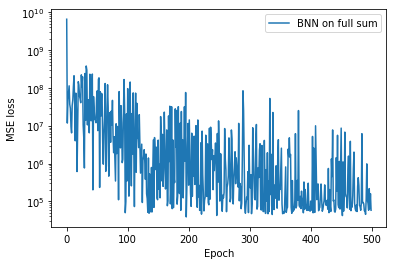

In [19]:
def plot_loss_arrays(loss_dict):
    for key in loss_dict.keys():
        plt.plot(loss_dict[key][0:], label=key)
    
    plt.yscale('log')
    #plt.xscale('log')
    plt.ylabel('MSE loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    return
    
plot_loss_arrays({model_name : loss_arr})

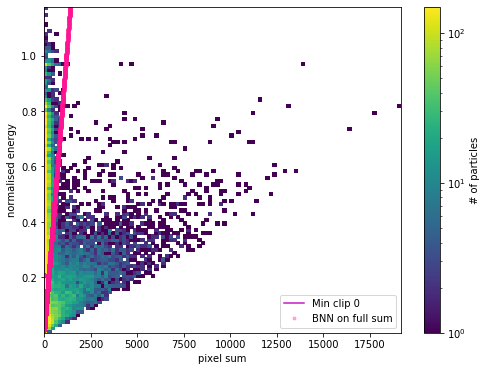

In [20]:
model_visualisation.plot_2d_energy_hist_clip(X_sum, y_train, y_pred, 0, model_name,
                                             save_file_prefix=save_file_prefix) 

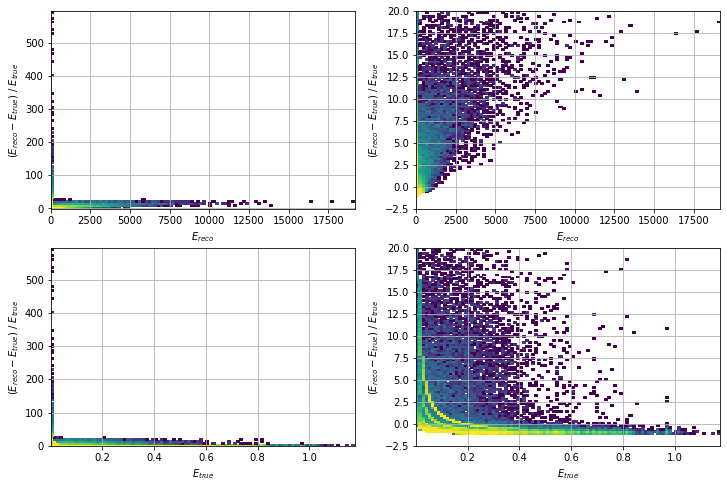

In [21]:
model_visualisation.plot_res_vs_energy(X_sum, y_train, y_pred, vmax=450,
                                       save_file_prefix=save_file_prefix) 

mean   = 1.12097e+00
std    = 8.19887e+00
median = -5.86241e-01


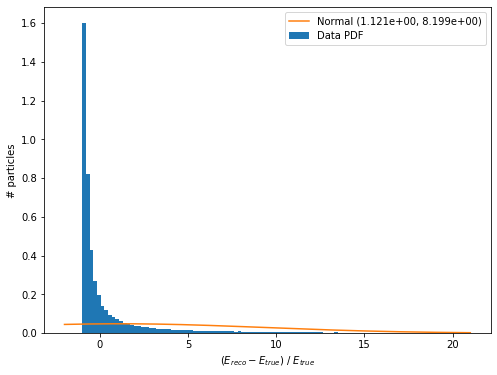

In [22]:
model_visualisation.plot_res_hist_fit(y_train, y_pred, [-1,20],
                                      save_file_prefix=save_file_prefix)

In [23]:
model_evaluation.save_scores(y_train, y_pred, save_file_prefix)

explained_variance_score -6.614871456593387
max_error 15.184105755464529
mean_absolute_error 0.22749416126519828
mean_squared_error 0.24433947230904607
median_absolute_error 0.13189986605110435
r2_score -6.6373394556474


,BNN-on-full-sum
explained_variance_score,-6.614871
max_error,15.184106
mean_absolute_error,0.227494
mean_squared_error,0.244339
median_absolute_error,0.131900
r2_score,-6.637339
avg_resolution,1.120973
std_resolution,8.198869


## Validation

In [24]:
X_sum_test = X_test.sum(axis=1).reshape(-1,1)
y_test = y_test.reshape(-1,1)

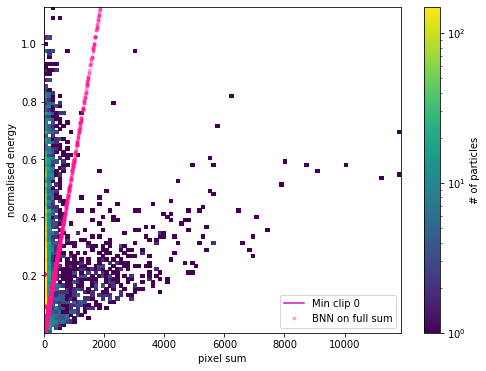

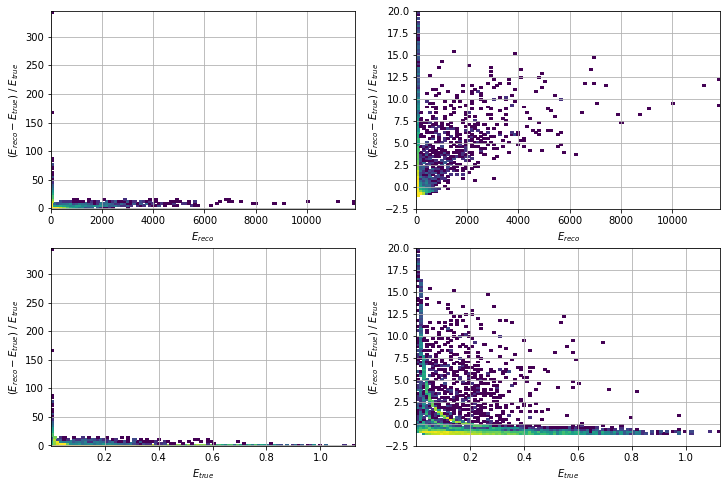

mean   = 7.23605e-01
std    = 5.61216e+00
median = -7.50834e-01


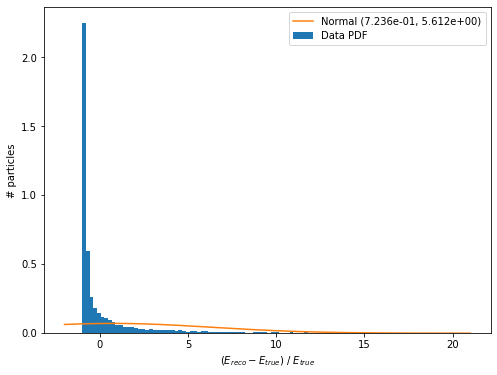

explained_variance_score -3.1749834388712506
max_error 6.641919320925814
mean_absolute_error 0.21227867247508506
mean_squared_error 0.13775682922678797
median_absolute_error 0.13900640614665177
r2_score -3.319428344708328


,BNN-on-full-sum
explained_variance_score,-3.174983
max_error,6.641919
mean_absolute_error,0.212279
mean_squared_error,0.137757
median_absolute_error,0.139006
r2_score,-3.319428
avg_resolution,0.723605
std_resolution,5.612163


In [25]:
samples = predictive(X_test_tens, y_test_tens)
pred_summary = summary(samples)
y_pred_test = pred_summary['_RETURN']['mean'].detach().cpu().numpy()


model_visualisation.plot_2d_energy_hist_clip(X_sum_test, y_test, y_pred_test, min_clip, model_name,
                                             save_file_prefix=save_file_prefix) 

model_visualisation.plot_res_vs_energy(X_sum_test, y_test, y_pred_test, vmax=150,
                                       save_file_prefix=save_file_prefix)  

model_visualisation.plot_res_hist_fit(y_test, y_pred_test, [-1,20],
                                      save_file_prefix=save_file_prefix)

model_evaluation.save_scores(y_test, y_pred_test, save_file_prefix, 
                             folder_path=model_evaluation.TEST_SCORES_DIR)